In [2]:
using ITensors, ITensorMPS
using Plots
using Random
using Statistics 

In [3]:


"""
    create_weighted_adj_mat(N::Int, σ::Float64; μ::Float64=1.0)

Creates a weighted adjacency matrix for a completely connected graph of N nodes.

- If σ = 0.0, it represents a homogeneous graph where all weights are 1.0.
- If σ > 0.0, it represents an inhomogeneous graph where weights are drawn
  from a Gaussian distribution with mean μ and standard deviation σ.
"""
function create_weighted_adj_mat(N::Int, σ::Float64; μ::Float64=1.0)

    if σ == 0.0
        A = ones(Float64, N, N)
        for i in 1:N; A[i, i] = 0.0; end 
        return A
    end
    
    A = zeros(Float64, N, N)
    for i in 1:N
        for j in (i+1):N
            weight = μ + σ * randn()
            A[i, j] = weight
            A[j, i] = weight 
        end
    end
    return A
end

create_weighted_adj_mat

In [4]:



"""
    create_weighted_xxz_mpo(N::Int, adj_mat, sites)

Creates the MPO for the XXZ Hamiltonian on a graph with weighted interactions.
The J and Δ values do not affect the bond dimension but are included for completeness.
"""
function create_weighted_xxz_mpo(N::Int, adj_mat, sites; J::Float64=1.0, Δ::Float64=1.0)
    ampo = OpSum()
    for i in 1:N-1
        for j in i+1:N
            coupling_strength = adj_mat[i, j]
            if coupling_strength != 0.0
                ampo += coupling_strength * (J / 2), "S+", i, "S-", j
                ampo += coupling_strength * (J / 2), "S-", i, "S+", j
                ampo += coupling_strength * (J * Δ), "Sz", i, "Sz", j
            end
        end
    end
    H = MPO(ampo, sites)
    return H
end

create_weighted_xxz_mpo

In [5]:

function plot_bond_dimensions()

    N_range = 10:2:100      # System sizes from 10 to 100 nodes
    num_graphs_avg = 10     # Number of random graphs to average over, same as Ash
    sigma_values = [0.0, 0.002]


    results = Dict(σ => Float64[] for σ in sigma_values)

    for N in N_range
        sites = ITensors.siteinds("S=1/2", N) 

        for σ in sigma_values
            if σ == 0.0

                adj_mat = create_weighted_adj_mat(N, σ)
                H_mpo = create_weighted_xxz_mpo(N, adj_mat, sites)
                bond_dim = maxlinkdim(H_mpo)
                push!(results[σ], bond_dim)
            else

                bond_dims_for_avg = []
                for _ in 1:num_graphs_avg
                    adj_mat = create_weighted_adj_mat(N, σ)
                    H_mpo = create_weighted_xxz_mpo(N, adj_mat, sites)
                    push!(bond_dims_for_avg, maxlinkdim(H_mpo))
                end
                avg_bond_dim = mean(bond_dims_for_avg)
                push!(results[σ], avg_bond_dim)
            end
        end
        println("Completed N = $N. [σ=0, χ=$(results[0.0][end])], [σ=0.002, χ≈$(round(results[0.002][end], digits=1))]")
    end

    plt = plot(
        title="Saturated Bond Dimension for an Average Graph",
        xlabel="Number of Nodes",
        ylabel="Bond Dimension Required",
        legend=:topleft,
        gridalpha=0.3
    )

    plot!(plt, N_range, results[0.0], label="σ=0", marker=:circle, color=:purple, lw=2)
    plot!(plt, N_range, results[0.002], label="σ=0.002", marker=:circle, color=:orange, lw=2)

    return plt
end



plot_bond_dimensions (generic function with 1 method)

In [6]:
# plt = plot_bond_dimensions();
# display(plt)
# # THIS TOOK 33m 46.2s TO RUN. PLEASE USE THE ARRAYS BELOW TO PLOT THE OUTPUTS AS I HAVE SAVED ALL THE VALUES 

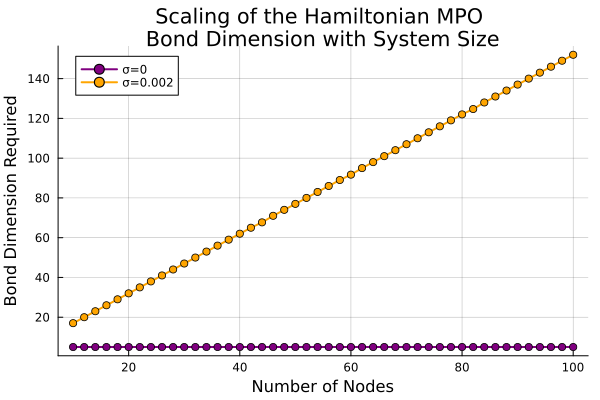

In [9]:

N_values = [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]
chi_sigma_0 = [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]
chi_sigma_0002 = [17.0, 20.0, 23.0, 26.0, 29.0, 32.0, 35.0, 38.0, 41.0, 44.0, 47.0, 50.0, 53.0, 56.0, 59.0, 62.0, 65.0, 67.7, 71.0, 74.0, 77.0, 80.0, 83.0, 86.0, 89.0, 91.7, 95.0, 98.0, 101.0, 104.0, 107.0, 110.0, 113.0, 116.0, 119.0, 122.0, 124.7, 128.0, 131.0, 134.0, 137.0, 140.0, 143.0, 146.0, 149.0, 152.0]

plt = plot(
    title="Scaling of the Hamiltonian MPO \nBond Dimension with System Size",
    xlabel="Number of Nodes",
    ylabel="Bond Dimension Required",
    legend=:topleft,
    gridalpha=0.3
)

plot!(plt, N_values, chi_sigma_0,
    label="σ=0",
    marker=:circle,
    color=:purple,
    lw=2  
)

plot!(plt, N_values, chi_sigma_0002,
    label="σ=0.002",
    marker=:circle,
    color=:orange,
    lw=2
)

savefig(plt, joinpath(@__DIR__, "ham_bd_scaling.png"))

display(plt)
